更新规则:
$$
\theta_{t+1} = \theta_t +\alpha \frac{\hat{A}(s,a)\nabla\pi_{\theta_t}(a|s)}{\pi_\theta(a|s)}\\
\theta_{t+1} = \theta_t +\alpha\hat{A}(s,a)\nabla_\theta \log\pi_\theta(s|a)
$$
Loss function:
$$
-\hat{A}(s,a)\log\pi(s|a)
$$
1.$\hat{A}(s,a)$为advantage function,$\pi_\theta(s|a)$为在s采取动作a的可能性，可将其导数理解为在s采取动作a这个向量。可以用简单的$f(x)=x$来理解

2.除上$\pi_\theta(a|s)$是因为让小概率的动作获得较大的增长空间(增长可正可负)

3.理解loss function:对loss求导才会有更新操作，所以Loss中没有求导

In [1]:
import gym
from itertools import count #一个高效的迭代器
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v1')
env.seed(42)
gamma = 0.9
torch.manual_seed(2) #为CPU设备设置种子用于生成随机数，让torch.rand(n)每次生成的随机数是确定的

In [3]:
#Policy 网络
class Policy(nn.Module):
    def __init__(self):
        #引用nn.Module的__init__()，等价于nn.Module.__init(self)
        super(Policy,self).__init__()
        self.Line1 = nn.Linear(4,128)
        self.dropout = nn.Dropout(p=0.5)
        self.Line2 = nn.Linear(128,2)
        
        self.saved_log_probs = []
        self.rewards = []
    
    def forward(self,x):
        x = self.Line1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.Line2(x)
        softmax_scores = F.softmax(action_scores,dim=1)
        return softmax_scores

In [4]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(),lr=1e-2)
eps = np.finfo(np.float32).eps.item()

In [5]:
def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()

In [6]:
def finish_episode():
    policy_loss = []
    R = 0
    returns = []
    for r in policy.rewards[::-1]:
        R = r + R*gamma
        returns.insert(0,R)
    returns = torch.tensor(returns)
    returns = (returns -returns.mean())/(returns.std() + eps)# +eps??
    for log_prob, R in zip(policy.saved_log_probs,returns):
        policy_loss.append(-log_prob*R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    #清空数据
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [7]:
def plot_reward(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.title('frame %s. mean_reward: %s'%(frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.xlabel('epoch')
    plt.ylabel('reward')
    plt.show()

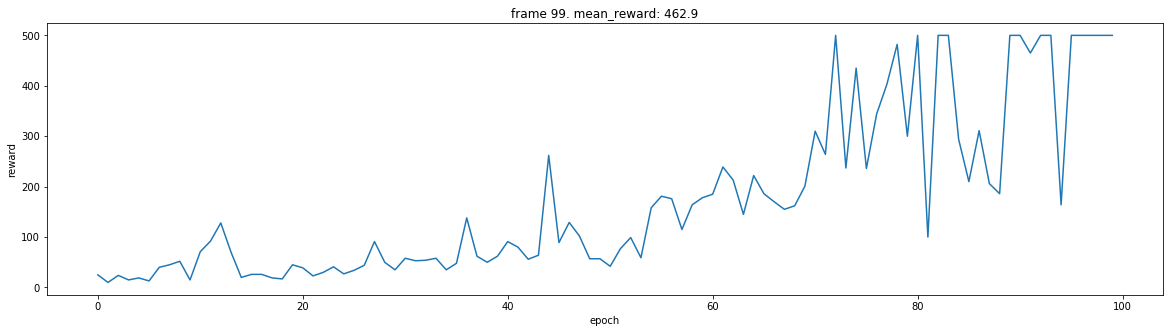

In [8]:
running_reward = []
for episode in range(100):
    state, ep_reward = env.reset(), 0
    for i in range(1,10000):
        action = select_action(state)
        state, reward, done, _ = env.step(action)
        policy.rewards.append(reward)
        ep_reward += reward
        if done:
            break
    running_reward.append(ep_reward)
    finish_episode()
    plot_reward(episode,running_reward)

In [9]:
probs1 = torch.tensor([0.25,0.25,0.25,0.24])
m1 = Categorical(probs1)#对probs求自然对数
action1 = m1.sample()#对自然对数m进行sample，返回索引值
print(action1.item())
print(m1.log_prob(action1))#记录被sample到的action的对数值

2
tensor(-1.3762)


In [10]:
np.finfo(np.float32).eps.item()

1.1920928955078125e-07